In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the datasets
all_data_path = 'all_data.csv'
election_results_path = 'HoC-GE2019-results-by-constituency.csv'

all_data = pd.read_csv(all_data_path)
election_results = pd.read_csv(election_results_path)

# Filter out the discrepancy from the all_data dataset
all_data_filtered = all_data[all_data['con_name'] != 'Ynys Mon']

# Define the variables of interest
variables_of_interest = [
    "Percentage of people aged 18-24", "Percentage of people aged 65+", 
    "Percentage of people born outside the UK", "Percentage of people who have a religion", 
    "Percentage of households that are owner-occupiers", "Percentage of households that are families with dependent children", 
    'Percentage of 16+ year olds in "routine and manual" occupations', 
    "Percentage of 16+ year olds with higher education qualifications", 
    "Percentage of people who are White", "Percentage of people who are disabled", 
    "Percentage of people aged 16+ identifying as LGB+", "Percentage of people aged 16+ who are veterans"
]

# Filter the all_data dataset to only include rows with the variables of interest
all_data_filtered = all_data_filtered[all_data_filtered['var_name'].isin(variables_of_interest)]

# Pivot the filtered all_data to have variables as columns
all_data_pivoted = all_data_filtered.pivot(index='con_name', columns='var_name', values='var_pc').reset_index()

# Merge the pivoted data with the election results
merged_data = pd.merge(election_results, all_data_pivoted, left_on='Constituency name', right_on='con_name', how='inner')

# Normalize the votes for Con, Lab, LD, SNP by the Valid votes
merged_data['Con'] = merged_data['Con'] / merged_data['Valid votes']
merged_data['Lab'] = merged_data['Lab'] / merged_data['Valid votes']
merged_data['LD'] = merged_data['LD'] / merged_data['Valid votes']
merged_data['SNP'] = merged_data['SNP'] / merged_data['Valid votes']

# Include the 'Region name' in the final dataframe
merged_data_with_region = pd.merge(merged_data, election_results[['Constituency name', 'Region name']], on='Constituency name', how='inner')

# Rename and select the correct 'Region name' column
merged_data_with_region = merged_data_with_region.rename(columns={'Region name_y': 'Region name'})

# Select the relevant columns including 'Region name'
final_columns_with_region = [
    'Constituency name', 'Region name', 'Member first name', 'Member surname', 'Member gender', 
    'Con', 'Lab', 'LD', 'SNP'
] + variables_of_interest

final_data_with_region = merged_data_with_region[final_columns_with_region]

# Save the final dataframe to a CSV file
output_path_with_region = "UK_2019_General_Election_Results_Analysis_with_Region.csv"
final_data_with_region.to_csv(output_path_with_region, index=False)

# Impute missing values in 'Percentage of people aged 16+ who are veterans' with the mean
final_data_with_region['Percentage of people aged 16+ who are veterans'].fillna(
    final_data_with_region['Percentage of people aged 16+ who are veterans'].mean(), 
    inplace=True
)

final_data_with_region.to_csv('demographics_and_vote_share.csv')

/tmp/ipykernel_3901/2246249801.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_with_region['Percentage of people aged 16+ who are veterans'].fillna(


/tmp/ipykernel_3901/2051714208.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(lab_coef.index, rotation=90)
/tmp/ipykernel_3901/2051714208.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(con_coef.index, rotation=90)


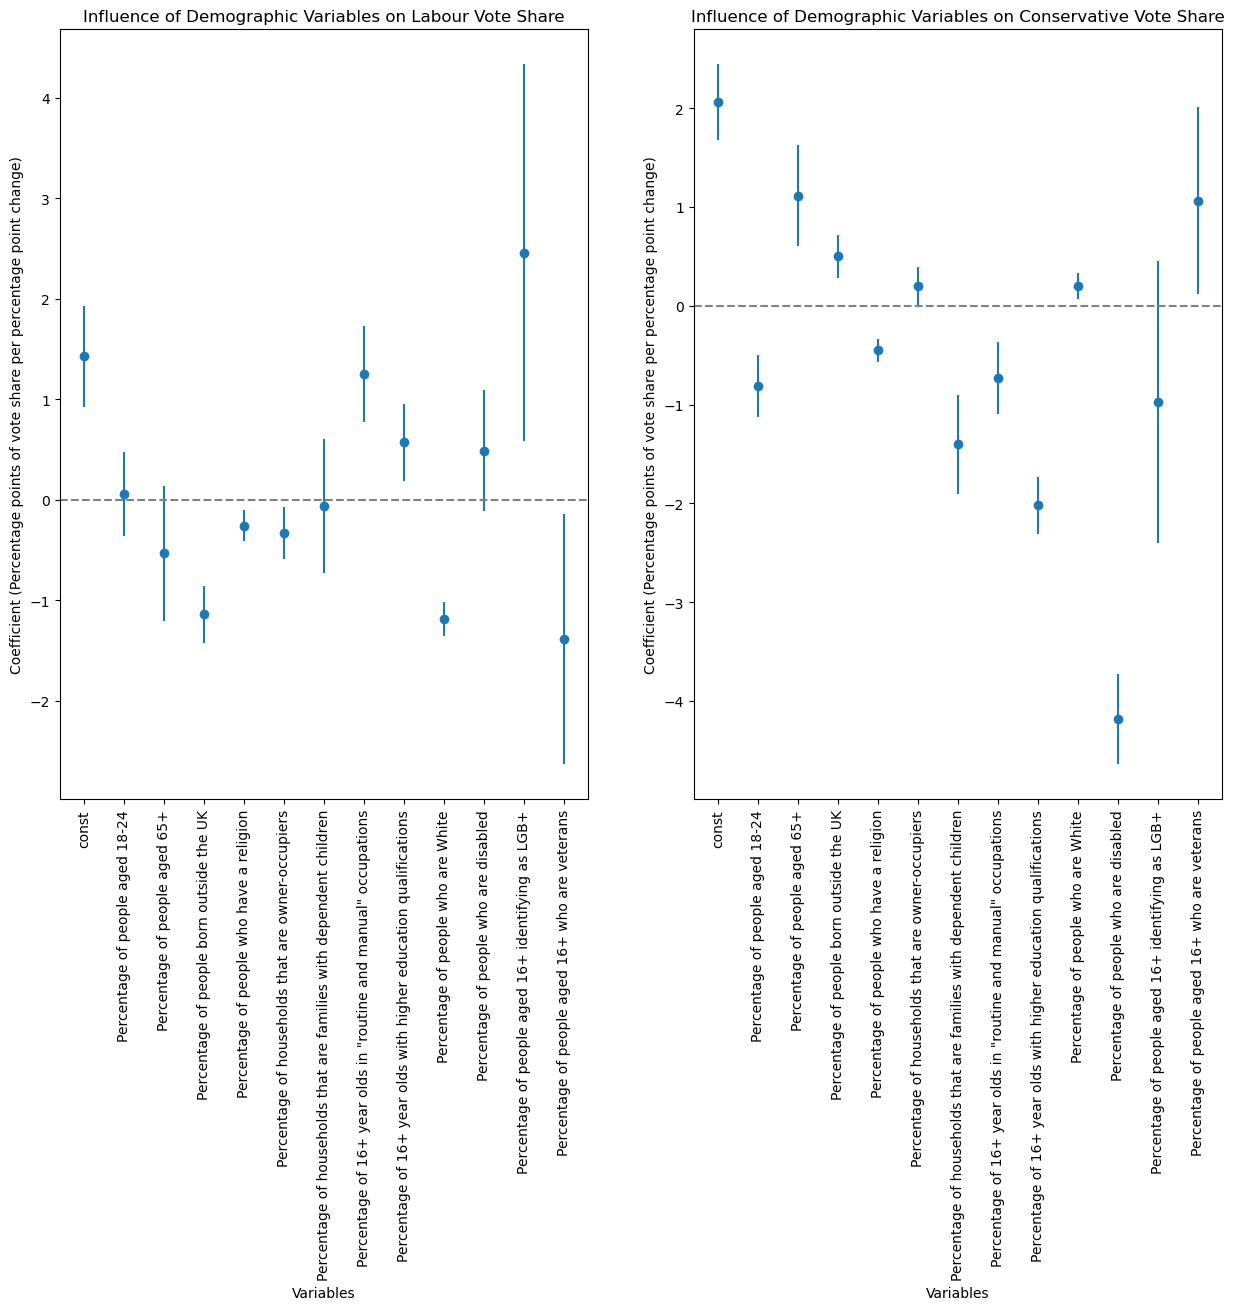

In [7]:
# Function to perform OLS regression and return the summary
# Define the dependent and independent variables
dependent_vars = ['Lab', 'Con']
independent_vars = [
    "Percentage of people aged 18-24", "Percentage of people aged 65+", 
    "Percentage of people born outside the UK", "Percentage of people who have a religion", 
    "Percentage of households that are owner-occupiers", "Percentage of households that are families with dependent children", 
    'Percentage of 16+ year olds in "routine and manual" occupations', 
    "Percentage of 16+ year olds with higher education qualifications", 
    "Percentage of people who are White", "Percentage of people who are disabled", 
    "Percentage of people aged 16+ identifying as LGB+", "Percentage of people aged 16+ who are veterans"
]

def ols_regression(dependent_var, independent_vars, data):
    X = data[independent_vars]
    y = data[dependent_var]
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    model = sm.OLS(y, X).fit()
    return model

# Perform OLS regression for Labour and Conservative vote shares
lab_model = ols_regression('Lab', independent_vars, final_data_with_region)
con_model = ols_regression('Con', independent_vars, final_data_with_region)

# Extracting the coefficients and confidence intervals
lab_coef = lab_model.params
lab_ci = lab_model.conf_int(alpha=0.05)
con_coef = con_model.params
con_ci = con_model.conf_int(alpha=0.05)

# Plotting the forest plot with units in the label and ensuring the x-axis label is not cut off
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

# Labour plot
axes[0].errorbar(lab_coef.index, lab_coef, yerr=[lab_coef - lab_ci[0], lab_ci[1] - lab_coef], fmt='o')
axes[0].axhline(xmin=0, xmax=1, y=0, color='grey', linestyle='--')
axes[0].set_title('Influence of Demographic Variables on Labour Vote Share')
axes[0].set_xlabel('Variables')
axes[0].set_ylabel('Coefficient (Percentage points of vote share per percentage point change)')
axes[0].set_xticklabels(lab_coef.index, rotation=90)

# Conservative plot
axes[1].errorbar(con_coef.index, con_coef, yerr=[con_coef - con_ci[0], con_ci[1] - con_coef], fmt='o')
axes[1].axhline(xmin=0, xmax=1, y=0, color='grey', linestyle='--')
axes[1].set_title('Influence of Demographic Variables on Conservative Vote Share')
axes[1].set_xlabel('Variables')
axes[1].set_ylabel('Coefficient (Percentage points of vote share per percentage point change)')
axes[1].set_xticklabels(con_coef.index, rotation=90)

# plt.tight_layout()
plt.savefig("OLS_Regression_Forest_Plot.png", bbox_inches='tight')
plt.show()



In [8]:
# Calculate the adjusted R-squared for both models
lab_adj_r_squared = lab_model.rsquared_adj
con_adj_r_squared = con_model.rsquared_adj

lab_adj_r_squared, con_adj_r_squared

(0.6500050396415145, 0.7844549533594473)

In [29]:
leaflet_data_path = 'processed_leaflets_data.csv'
leaflet_data = pd.read_csv(leaflet_data_path)

# Create a dictionary for mapping constituency names from leaflet data to final data
constituency_mapping = {
    'Ealing Southall': 'Ealing, Southall',
    'Birmingham Ladywood': 'Birmingham, Ladywood',
    'Normanton Pontefract and Castleford': 'Normanton, Pontefract and Castleford',
    'Cities of London and Westminster': 'Cities Of London and Westminster',
    'Liverpool Riverside': 'Liverpool, Riverside',
    'Southampton Itchen': 'Southampton, Itchen',
    'Stoke-on-Trent South': 'Stoke-On-Trent South',
    'Sheffield Hallam': 'Sheffield, Hallam',
    'Ashton-under-Lyne': 'Ashton-Under-Lyne',
    'Isle of Wight': 'Isle Of Wight',
    'Newcastle-under-Lyme': 'Newcastle-Under-Lyme',
    'Brighton Kemptown': 'Brighton, Kemptown',
    'Manchester Withington': 'Manchester, Withington',
    'Sheffield Heeley': 'Sheffield, Heeley',
    'Vale of Glamorgan': 'Vale Of Glamorgan',
    'Newcastle upon Tyne Central': 'Newcastle Upon Tyne Central',
    'Southampton Test': 'Southampton, Test',
    'Lewisham Deptford': 'Lewisham, Deptford',
    'Plymouth Sutton and Devonport': 'Plymouth, Sutton and Devonport',
    'Birmingham Erdington': 'Birmingham, Erdington',
    'Stoke-on-Trent Central': 'Stoke-On-Trent Central',
    'City of Durham': 'City Of Durham'
}

# Apply the mapping to the leaflet data
leaflet_data['Constituency'] = leaflet_data['Constituency'].replace(constituency_mapping)

# Merge the entire leaflet dataframe with the final_data_with_region dataframe
merged_leaflet_data = pd.merge(
    leaflet_data,
    final_data_with_region,
    left_on='Constituency',
    right_on='Constituency name',
    how='left'
)

merged_leaflet_data.head()

,leaflet_ID,Party,Constituency,mention_Candidate,mention_Other party/leader/candidate,mention_Party leader,mention_Tactical situation,issue_Brexit/Europe,issue_Economy,issue_Education,...,Percentage of people born outside the UK,Percentage of people who have a religion,Percentage of households that are owner-occupiers,Percentage of households that are families with dependent children,"Percentage of 16+ year olds in ""routine and manual"" occupations",Percentage of 16+ year olds with higher education qualifications,Percentage of people who are White,Percentage of people who are disabled,Percentage of people aged 16+ identifying as LGB+,Percentage of people aged 16+ who are veterans
0,31182,Liberal Democrats,Cambridge,1,1,0,0,0,0,0,...,0.380726,0.452242,0.451022,0.255128,0.145745,0.474119,0.748935,0.147779,0.066458,0.015455
1,31193,Conservative Party,South Holland and The Deepings,1,0,0,0,1,0,0,...,0.134270,0.595555,0.712989,0.259644,0.326656,0.177218,0.963464,0.185402,0.017307,0.047634
2,31210,Liberal Democrats,South Cambridgeshire,1,0,0,0,0,0,1,...,0.176117,0.499847,0.712654,0.313853,0.154924,0.395419,0.874070,0.145341,0.025914,0.027637
3,31222,Labour Party,Aberconwy,0,1,0,0,1,0,0,...,0.056043,0.525221,0.694332,0.221895,0.267434,0.287266,0.972811,0.211588,0.023176,0.049277
4,31260,Conservative Party,Sittingbourne and Sheppey,1,1,1,0,1,0,0,...,0.082824,0.495411,0.681102,0.313937,0.276658,0.172372,0.932924,0.195660,0.022989,0.031007


In [30]:
merged_leaflet_data.to_csv('merged_leaflet_data.csv')

In [31]:
# List of integer columns to be modified
integer_columns = [
    "num_key_policies", "num_quantitative_statements", "num_qualitative_statements",
    "num_local_issues", "num_national_issues", "num_endorsements",
    "negative_local_issues", "negative_national_issues", "negative_leader_of_opponents_party",
    "negative_opposite_candidate_no_name", "negative_opposite_candidate_with_name"
]

# Convert integer columns to binary (1 or more to True, 0 to False)
for column in integer_columns:
    merged_leaflet_data[column] = merged_leaflet_data[column] >= 1

# Define clearer names for leaflet variables
leaflet_variable_names = {
    "mention_Candidate": "Mentions Candidate",
    "mention_Other party/leader/candidate": "Mentions Other Party/Leader/Candidate",
    "mention_Party leader": "Mentions Party Leader",
    "mention_Tactical situation": "Mentions Tactical Situation",
    "issue_Brexit/Europe": "Mentions Brexit/Europe",
    "issue_Economy": "Mentions Economy",
    "issue_Education": "Mentions Education",
    "issue_Environment": "Mentions Environment",
    "issue_Governance": "Mentions Governance",
    "issue_Health": "Mentions Health",
    "issue_Immigration": "Mentions Immigration",
    "issue_Social welfare": "Mentions Social Welfare",
    "is_local": "Is Local"
}

# Rename the columns
merged_leaflet_data.rename(columns=leaflet_variable_names, inplace=True)

# One-hot encode the integer columns and the categorical 'yimby_nimby' column
merged_leaflet_data_encoded = pd.get_dummies(merged_leaflet_data, columns=integer_columns + ['yimby_nimby'], drop_first=True)

# Define the expected leaflet variables after encoding
leaflet_variable_names_corrected = [
    "Mentions Candidate", "Mentions Other Party/Leader/Candidate", "Mentions Party Leader",
    "Mentions Tactical Situation", "Mentions Brexit/Europe", "Mentions Economy", "Mentions Education",
    "Mentions Environment", "Mentions Governance", "Mentions Health", "Mentions Immigration", "Mentions Social Welfare",
    "Is Local", "num_key_policies_True", "num_quantitative_statements_True",
    "num_qualitative_statements_True", "num_local_issues_True", "num_national_issues_True", "num_endorsements_True",
    "negative_local_issues_True", "negative_national_issues_True", "negative_leader_of_opponents_party_True",
    "negative_opposite_candidate_no_name_True", "negative_opposite_candidate_with_name_True",
    "yimby_nimby_OTHER", "yimby_nimby_YIMBY"
]

# Check which expected columns are missing from the dataframe
missing_columns = [col for col in leaflet_variable_names_corrected if col not in merged_leaflet_data_encoded.columns]

# Print the missing columns
print("Missing columns after renaming and one-hot encoding:", missing_columns)


Missing columns after renaming and one-hot encoding: []


Adjusted R² for Labour (Demographics only): 0.8044345703715107
Adjusted R² for Conservative (Demographics only): 0.8445054134710843
Adjusted R² for Labour (Demographics + Leaflet variables): 0.8052394923347479
Adjusted R² for Conservative (Demographics + Leaflet variables): 0.8470003607394524


/tmp/ipykernel_3901/1379925309.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(lab_coef_demographics.index, rotation=90)
/tmp/ipykernel_3901/1379925309.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(con_coef_demographics.index, rotation=90)


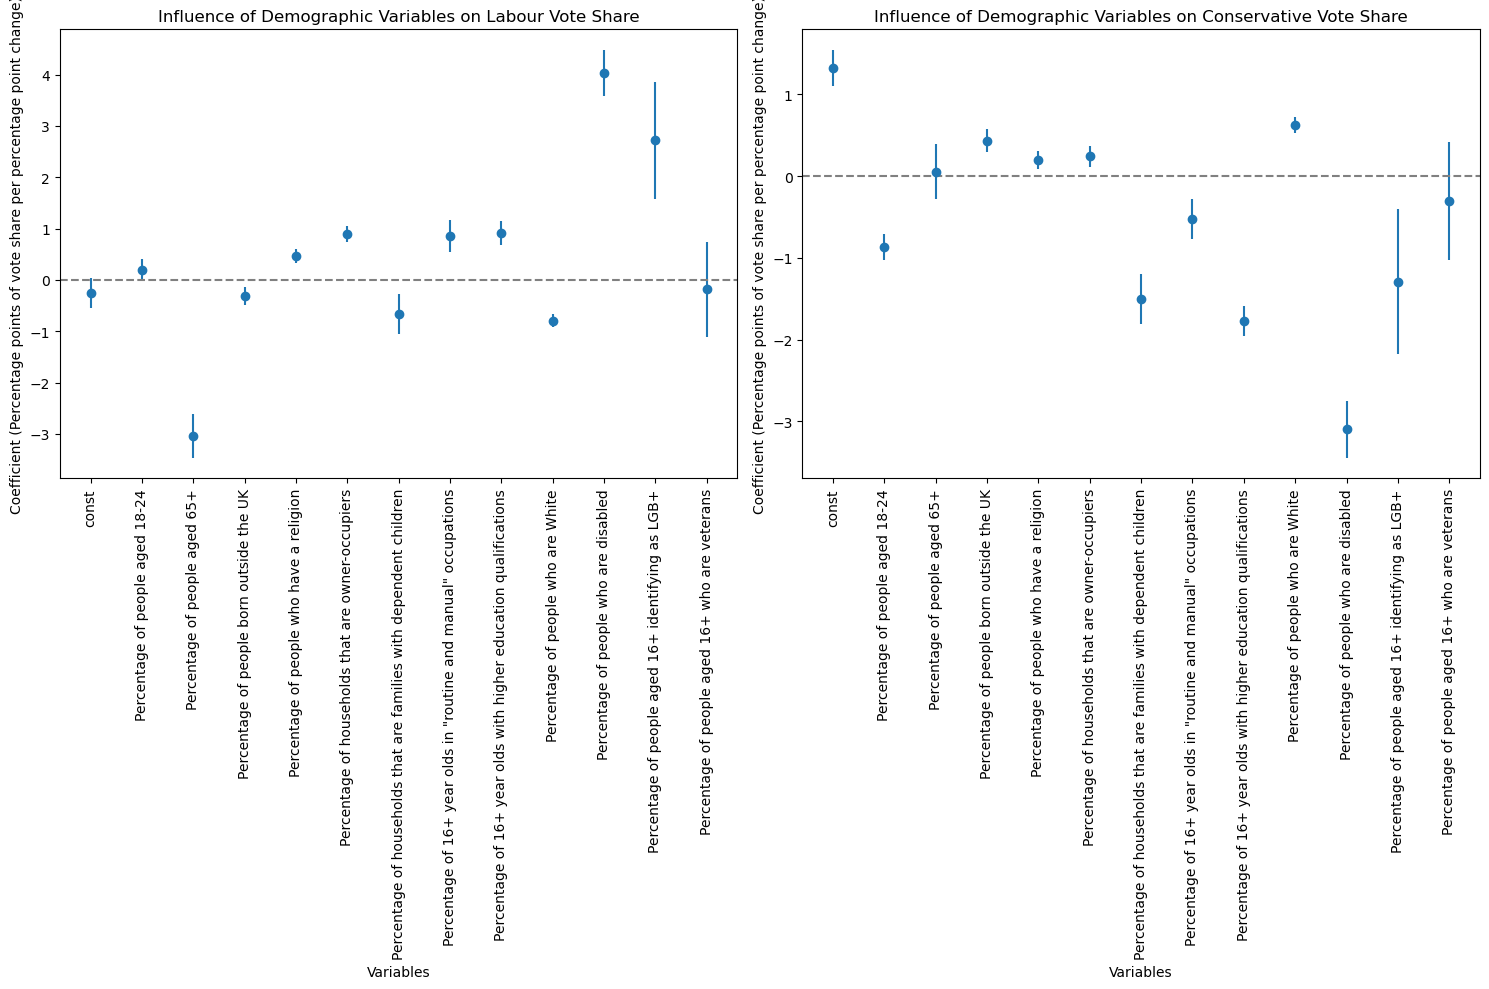

/tmp/ipykernel_3901/1379925309.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(lab_coef_leaflets_all_vars_corrected.index, rotation=90)
/tmp/ipykernel_3901/1379925309.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(con_coef_leaflets_all_vars_corrected.index, rotation=90)


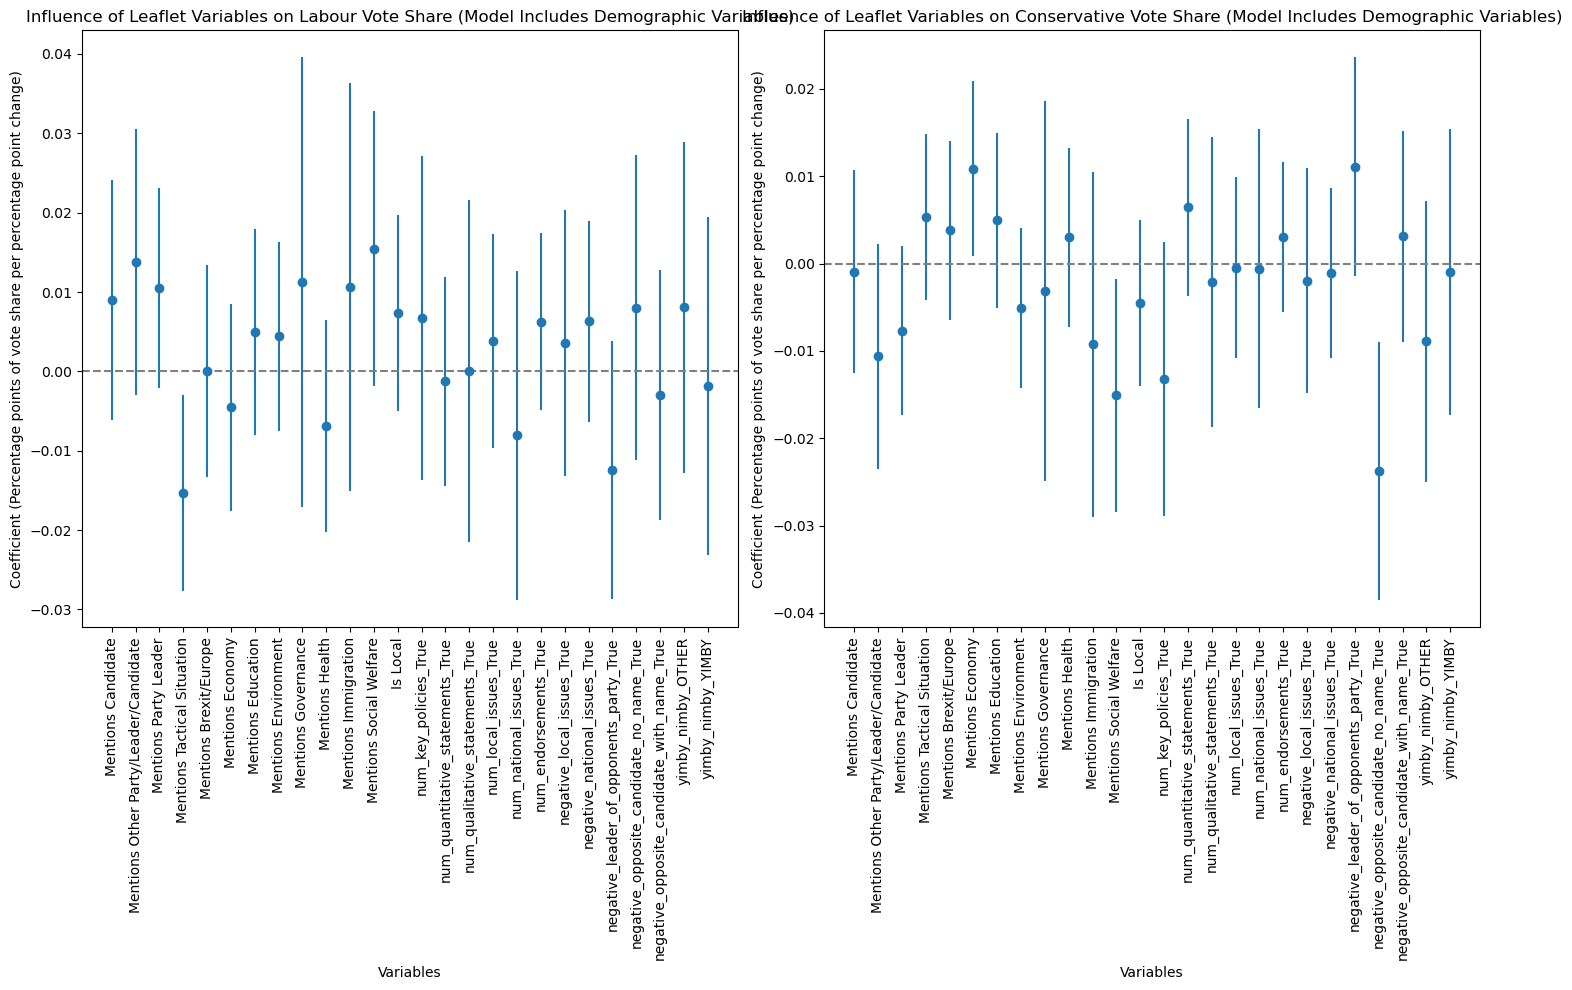

In [36]:
# Combine demographic variables and updated leaflet variables
all_updated_independent_vars_binary_clear = independent_vars + leaflet_variable_names_corrected

# Ensure all columns used in the regression are numeric
for col in all_updated_independent_vars_binary_clear + dependent_vars:
    merged_leaflet_data_encoded[col] = pd.to_numeric(merged_leaflet_data_encoded[col], errors='coerce')

# Explicitly convert boolean columns to integers
boolean_columns = merged_leaflet_data_encoded.select_dtypes(include='bool').columns
merged_leaflet_data_encoded[boolean_columns] = merged_leaflet_data_encoded[boolean_columns].astype(int)

# Drop rows with NaN values in these columns after converting to numeric
filtered_data_all_vars = merged_leaflet_data_encoded.dropna(subset=all_updated_independent_vars_binary_clear + dependent_vars)

# Verify data types
# print(filtered_data_all_vars.dtypes)

# Perform OLS regression for Labour and Conservative vote shares with demographic and leaflet variables
lab_model_all_vars = ols_regression('Lab', all_updated_independent_vars_binary_clear, filtered_data_all_vars)
con_model_all_vars = ols_regression('Con', all_updated_independent_vars_binary_clear, filtered_data_all_vars)

# Extracting the coefficients and confidence intervals for all variables
lab_coef_all_vars = lab_model_all_vars.params
lab_ci_all_vars = lab_model_all_vars.conf_int(alpha=0.05)
con_coef_all_vars = con_model_all_vars.params
con_ci_all_vars = con_model_all_vars.conf_int(alpha=0.05)

# Calculate the adjusted R-squared for models with all variables
lab_adj_r_squared_all_vars = lab_model_all_vars.rsquared_adj
con_adj_r_squared_all_vars = con_model_all_vars.rsquared_adj

# Print adjusted R-squared values
print(f"Adjusted R² for Labour (Demographics only): {lab_adj_r_squared_demographics}")
print(f"Adjusted R² for Conservative (Demographics only): {con_adj_r_squared_demographics}")
print(f"Adjusted R² for Labour (Demographics + Leaflet variables): {lab_adj_r_squared_all_vars}")
print(f"Adjusted R² for Conservative (Demographics + Leaflet variables): {con_adj_r_squared_all_vars}")

# Extract coefficients and confidence intervals for leaflet variables only from the all variables model
lab_coef_leaflets_all_vars_corrected = lab_coef_all_vars[leaflet_variable_names_corrected]
lab_ci_leaflets_all_vars_corrected = lab_ci_all_vars.loc[leaflet_variable_names_corrected]
con_coef_leaflets_all_vars_corrected = con_coef_all_vars[leaflet_variable_names_corrected]
con_ci_leaflets_all_vars_corrected = con_ci_all_vars.loc[leaflet_variable_names_corrected]

# Plotting the forest plot with demographic variables only
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

# Labour plot for demographic variables only
axes[0].errorbar(lab_coef_demographics.index, lab_coef_demographics, yerr=[lab_coef_demographics - lab_ci_demographics[0], lab_ci_demographics[1] - lab_coef_demographics], fmt='o')
axes[0].axhline(xmin=0, xmax=1, y=0, color='grey', linestyle='--')
axes[0].set_title('Influence of Demographic Variables on Labour Vote Share')
axes[0].set_xlabel('Variables')
axes[0].set_ylabel('Coefficient (Percentage points of vote share per percentage point change)')
axes[0].set_xticklabels(lab_coef_demographics.index, rotation=90)

# Conservative plot for demographic variables only
axes[1].errorbar(con_coef_demographics.index, con_coef_demographics, yerr=[con_coef_demographics - con_ci_demographics[0], con_ci_demographics[1] - con_coef_demographics], fmt='o')
axes[1].axhline(xmin=0, xmax=1, y=0, color='grey', linestyle='--')
axes[1].set_title('Influence of Demographic Variables on Conservative Vote Share')
axes[1].set_xlabel('Variables')
axes[1].set_ylabel('Coefficient (Percentage points of vote share per percentage point change)')
axes[1].set_xticklabels(con_coef_demographics.index, rotation=90)

plt.tight_layout()
plt.savefig("OLS_Regression_Forest_Plot_Demographics_Only.png", bbox_inches='tight')
plt.show()

# Plotting the forest plot with leaflet variables only for the all variables model
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

# Labour plot for leaflet variables only
axes[0].errorbar(lab_coef_leaflets_all_vars_corrected.index, lab_coef_leaflets_all_vars_corrected, yerr=[lab_coef_leaflets_all_vars_corrected - lab_ci_leaflets_all_vars_corrected[0], lab_ci_leaflets_all_vars_corrected[1] - lab_coef_leaflets_all_vars_corrected], fmt='o')
axes[0].axhline(xmin=0, xmax=1, y=0, color='grey', linestyle='--')
axes[0].set_title('Influence of Leaflet Variables on Labour Vote Share (Model Includes Demographic Variables)')
axes[0].set_xlabel('Variables')
axes[0].set_ylabel('Coefficient (Percentage points of vote share per percentage point change)')
axes[0].set_xticklabels(lab_coef_leaflets_all_vars_corrected.index, rotation=90)

# Conservative plot for leaflet variables only
axes[1].errorbar(con_coef_leaflets_all_vars_corrected.index, con_coef_leaflets_all_vars_corrected, yerr=[con_coef_leaflets_all_vars_corrected - con_ci_leaflets_all_vars_corrected[0], con_ci_leaflets_all_vars_corrected[1] - con_coef_leaflets_all_vars_corrected], fmt='o')
axes[1].axhline(xmin=0, xmax=1, y=0, color='grey', linestyle='--')
axes[1].set_title('Influence of Leaflet Variables on Conservative Vote Share (Model Includes Demographic Variables)')
axes[1].set_xlabel('Variables')
axes[1].set_ylabel('Coefficient (Percentage points of vote share per percentage point change)')
axes[1].set_xticklabels(con_coef_leaflets_all_vars_corrected.index, rotation=90)

plt.tight_layout()
plt.savefig("OLS_Regression_Forest_Plot_Leaflet_Variables_Only_Corrected.png", bbox_inches='tight')
plt.show()


In [35]:
# Calculate the adjusted R-squared for both models
lab_adj_r_squared = lab_model.rsquared_adj
con_adj_r_squared = con_model.rsquared_adj

lab_adj_r_squared, con_adj_r_squared

(0.6500050396415145, 0.7844549533594473)